In [1]:
# import fastparquet

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
# import fastparquet as fp
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn import metrics
import matplotlib.pyplot as plt

df = pd.read_parquet("D:\\Zeina\\Uni\\Semester10\\Machine Learning\\Ms2\\encoded.parquet")
df['accident_severity'] = df['accident_severity'].replace({1: 'Slight',  0.5: 'Serious', 0: 'Fatal'})
df = pd.concat([df, pd.get_dummies(df['accident_severity'])], axis=1)
df['Serious'] = df['Serious'].astype(int)
df['Slight'] = df['Slight'].astype(int)
df['Fatal'] = df['Fatal'].astype(int)
le = LabelEncoder()
le.fit_transform(df['accident_severity'])
df['accident_severity'] = le.transform(df['accident_severity'])

df.head()

,Unnamed: 0,accident_index,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,time,local_authority_district,...,carriageway_hazards_Vehicle load on road,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Fatal,Serious,Slight
0,0,1991010SU0977,522100.0,200300.0,0.58,1,0.058824,0.0,0.565217,0.539301,...,0,1,0,0,0,0,0,0,1,0
1,1,199101AB00001,529970.0,178300.0,0.58,2,0.058824,0.0,0.000000,0.967249,...,0,0,0,1,0,0,0,0,0,1
2,2,199101AB00002,528910.0,178790.0,0.58,2,0.000000,0.0,0.521739,0.967249,...,0,0,0,1,0,0,0,0,0,1
3,3,199101AB00003,529910.0,179480.0,0.58,2,0.000000,0.0,0.347826,0.967249,...,0,0,0,0,0,0,0,0,0,1
4,4,199101AB00004,529810.0,178390.0,0.58,2,0.000000,0.0,0.521739,0.967249,...,0,0,1,0,0,0,0,0,0,1


In [3]:
print(df['accident_severity'].value_counts()) 

accident_severity
2    176112
1     40442
0      3736
Name: count, dtype: int64


#### We'll choose some input variables from the accident dataset as X, and the accident_severity feature as the target variable y as follows:

In [4]:
relevant_cols = [
'number_of_vehicles',
 'number_of_casualties',
 'speed_limit',
    'road_type_Single carriageway',
    'junction_detail_Not at junction or within 20 metres',
    'junction_detail_T or staggered junction',
    'road_surface_conditions_Wet or damp',
    'junction_control_Give way or uncontrolled',
    'pedestrian_crossing_human_control_None within 50 metres '
]
X = df[relevant_cols]

target=['Serious','Slight','Fatal']
y_detailed=df[target]
y_severity=df['accident_severity']

print(y_severity)
print(y_detailed)


0         1
1         2
2         2
3         2
4         2
         ..
220285    2
220286    1
220287    2
220288    1
220289    1
Name: accident_severity, Length: 220290, dtype: int32
        Serious  Slight  Fatal
0             1       0      0
1             0       1      0
2             0       1      0
3             0       1      0
4             0       1      0
...         ...     ...    ...
220285        0       1      0
220286        1       0      0
220287        0       1      0
220288        1       0      0
220289        1       0      0

[220290 rows x 3 columns]


### Get the best model through KFolds evaluation

#### First, we'll get the accuracy of NN, Logistic Regression, Naive Bayes and KNN models by evaluating different samples of the dataset, and divide each sample into train and test. Then, the average of the samples' accuracies is calculated to later compare the models.

In [5]:
def kfold_eval(X, y, model, n_folds):

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []

    for train, test in kf.split(X):

        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train)        
        y_pred = model.predict(X_test)

        
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    mean_accuracy = sum(accuracies) / n_folds

    print(f"{model} accuracy using Kfolds: {mean_accuracy}")

In [6]:
nfolds=10

lr = LogisticRegression()
kfold_eval(X, y_severity, lr, nfolds)

nb = GaussianNB()
kfold_eval(X, y_severity, nb, nfolds)

knn = KNeighborsClassifier() # default k = 5
kfold_eval(X, y_severity, knn, nfolds)

nn = MLPClassifier()   
kfold_eval(X, y_severity, nn, nfolds)

LogisticRegression() accuracy using Kfolds: 0.799936447410232
GaussianNB() accuracy using Kfolds: 0.7756502791774478
KNeighborsClassifier() accuracy using Kfolds: 0.7325116891370467
MLPClassifier() accuracy using Kfolds: 0.8002042761813973


#### It's clear that the nerual network classifer resulted in a better accuracy = 0.8002042761813973 which indicates that it's the best model among the 4 models for the data, with logistic regression following it with 0.799936447410232 accuracy

### Get the best model through Stratified Sampling evaluation

#### We'll evaluate the models with stratified sampling, where the data is divided into train and test, however, the sample taken of the data is representative of the overall dataset.

In [7]:
def stratified_sampling(X, y, model):
    X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model.fit(X_train_st, y_train_st)
    score_model = model.score(X_test_st, y_test_st)
    
    print(f"{model} accuracy using Stratified Sampling: {score_model}")


In [9]:
lr2 = LogisticRegression()
stratified_sampling(X, y_severity, lr2)

knn2 = KNeighborsClassifier()
stratified_sampling(X, y_severity, knn2)

nb2 = GaussianNB()
stratified_sampling(X, y_severity, nb2)

nn2 = MLPClassifier()
stratified_sampling(X, y_severity, nn2)

LogisticRegression() accuracy using Stratified Sampling: 0.8003313813609333
KNeighborsClassifier() accuracy using Stratified Sampling: 0.7748422533932543
GaussianNB() accuracy using Stratified Sampling: 0.7768169231467611
MLPClassifier() accuracy using Stratified Sampling: 0.8003540787144219


#### For startified sampling, neural networks model and logistic regression both show that they're the best models to model the data as they both have 0.8003 accuracy

### Confusion Matrix

A **confusion matrix** is a table that is used to evaluate the performance of a classification model. It is a table that shows the number of true positives, false positives, true negatives, and false negatives.

It is 3x3 as there are three classes in the classification problem. The rows represent the actual classes, whereas the columns represent the predicted classes. The diagonal elements represent the number of correct predictions for each class, while the off-diagonal elements represent the number of incorrect predictions.

#### The rest of the work is done on the train, test data of startified sampling 

In [33]:
lencoded_xtrain, lencoded_xtest, lencoded_ytrain, lencoded_ytest = train_test_split(X, y_severity, test_size=0.2, stratify=y_severity, random_state=42)

In [48]:
def confusion_matrix(labels, y_test, y_pred):

    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels= labels)
    # print(f"{model} confusion matrix using Kfolds: {confusion_matrix}")

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels) 
    cm_display.plot()
    plt.show()

Plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels yields the **ROC curve**.  Binary classification algorithms' performance is typically assessed using the ROC curve. In contrast to most other metrics, the ROC curve presents a graphical picture of a classifier's performance. 

The ability of the model to differentiate between positive and negative classes is measured by the **area under the ROC curve (AUC)**. An AUC of 1.0 indicates a flawless classifier, while an AUC of 0.5 indicates a random classifier.

In [15]:
from sklearn.preprocessing import label_binarize
#binarize the y_values
def roc1(x_test, y_test, model):
  model_probs = model.predict_proba(x_test)
  y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))
  false_pr = {}
  true_pr = {}
  threshold ={}
  roc_auc = dict()
  n_classes = model.classes_.shape[0]

  for i in range(n_classes):    
      false_pr[i], true_pr[i], threshold[i] = roc_curve(y_test_binarized[:,i], model_probs[:,i])
      roc_auc[i] = auc(false_pr[i], true_pr[i])
      plt.plot(false_pr[i], true_pr[i], linestyle='--', 
              label='%s vs Rest (AUC=%0.2f)'%(model.classes_[i],roc_auc[i]))

  plt.plot([0,1],[0,1],'b--')
  plt.xlim([0,1])
  plt.ylim([0,1.05])
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right')
  plt.show()

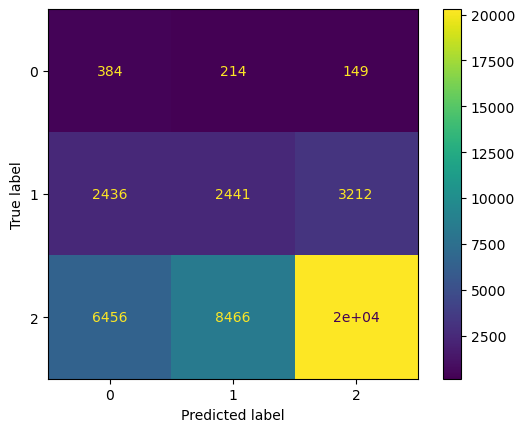

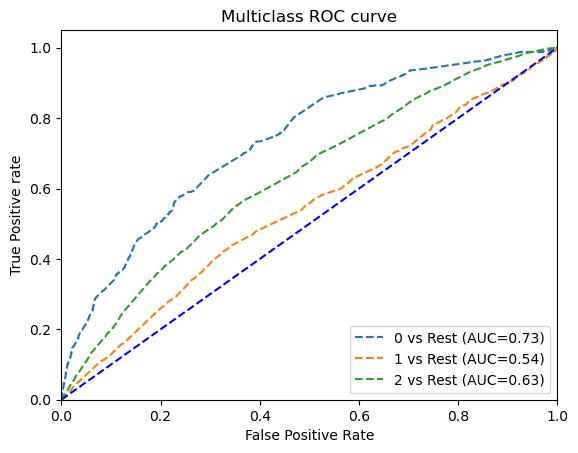

In [34]:
# logistic regression is done on 'accident_severity' target variable
lr_conf = LogisticRegression(multi_class='multinomial',class_weight='balanced')
lr_conf.fit(lencoded_xtrain, lencoded_ytrain)
lr_conf_y_pred = lr_conf.predict(lencoded_xtest)
# accuracy_score(lencoded_ytest, lr_y_pred)
confusion_matrix(lr_conf.classes_, lencoded_ytest, lr_conf_y_pred)
roc1(lencoded_xtest, lencoded_ytest, lr_conf)

#### Using logistic regression, class 0 got 384 out of 3736 true positives, class 1 got 2441 out of  40442 true positives, and class 2 got 20,000 out of 176112 true positives.

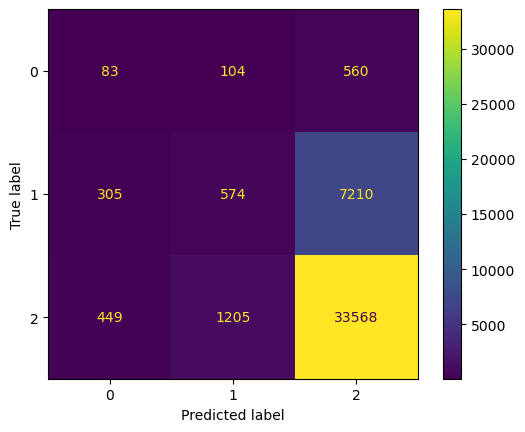

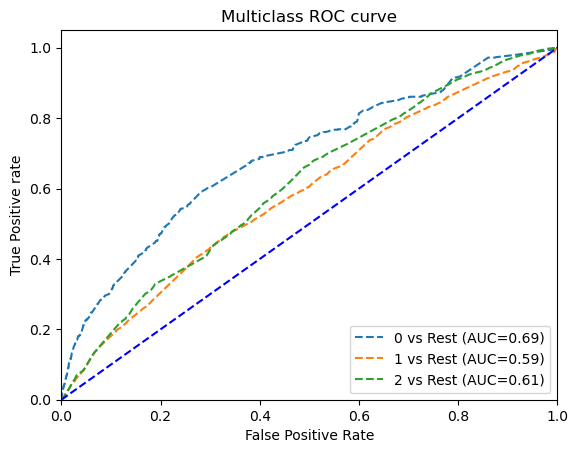

In [35]:
# naive bayes is done on 'accident_severity' target variable
nb_conf = GaussianNB()
nb_conf.fit(lencoded_xtrain, lencoded_ytrain)
nb_conf_y_pred = nb_conf.predict(lencoded_xtest)
confusion_matrix(nb_conf.classes_, lencoded_ytest, nb_conf_y_pred)
roc1(lencoded_xtest, lencoded_ytest, nb_conf)

#### Using naive bayes, class 0 got 83 out of 3736 true positives, class 1 got 574 out of 40442 true positives, and class 2 got 33568 out of 176112 true positives.

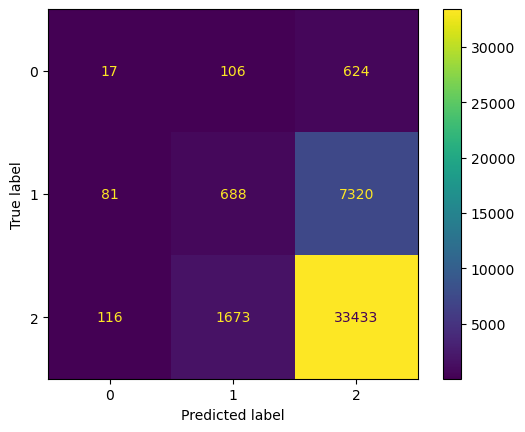

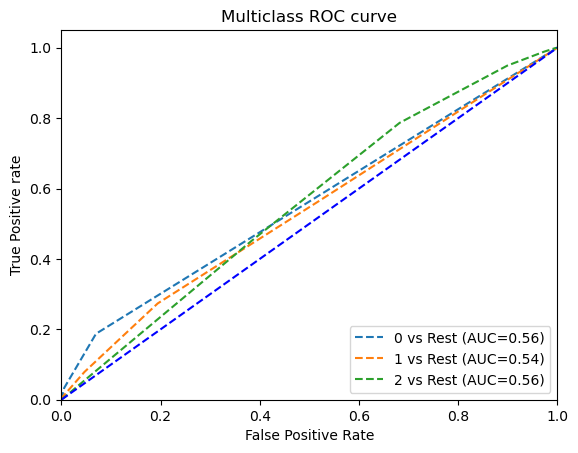

In [36]:
knn_conf = KNeighborsClassifier(n_neighbors=5) # default neighbors is 5
knn_conf.fit(lencoded_xtrain, lencoded_ytrain)
knn_conf_y_pred = knn_conf.predict(lencoded_xtest)
confusion_matrix(knn_conf.classes_, lencoded_ytest, knn_conf_y_pred)
roc1(lencoded_xtest, lencoded_ytest, knn_conf)

#### Using KNN, class 0 got 17 out of 3736 true positives, class 688 got 574 out of 40442 true positives, and class 2 got 33433 out of 176112 true positives.

[0 1 2]


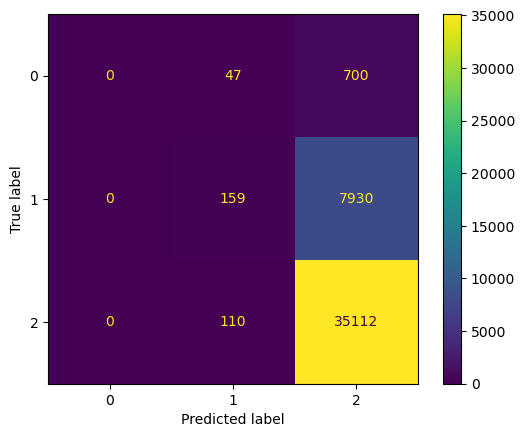

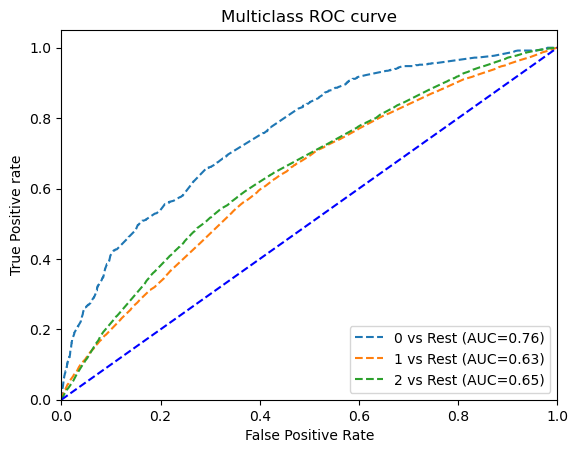

In [52]:
nn_conf = MLPClassifier()
nn_conf.fit(lencoded_xtrain, lencoded_ytrain)
nn_conf_y_pred = nn_conf.predict(lencoded_xtest)
print(nn_conf.classes_)
confusion_matrix(nn_conf.classes_, lencoded_ytest, nn_conf_y_pred)
roc1(lencoded_xtest, lencoded_ytest, nn_conf)

#### Using MLP, class 0 got 0 out of 3736 true positives, class 1 got 159 out of 40442 true positives, and class 2 got 35112 out of 176112 true positives.

#### It's clear that the since the data is unbalanced, as there's a huge difference between the data in class 0 and the other classes, which makes it a minority class. We'll test this by undersampling the majority classes as: undersampling is the process where we'll randomly delete some of the observations from the majority class in order to match the numbers with the minority class. So, we'll make all observations in classes 1 and 2 to be = observations in class 0 = 3736 

In [55]:
shuffled_df = df.sample(frac=1,random_state=4)
class0 = shuffled_df.loc[shuffled_df['accident_severity'] == 0]
class1 = shuffled_df.loc[shuffled_df['accident_severity'] == 1].sample(n=3736,random_state=42)
class2 = shuffled_df.loc[shuffled_df['accident_severity'] == 2].sample(n=3736,random_state=42)

normalized_df = pd.concat([class0, class1, class2])

X1 = normalized_df[relevant_cols]

y1_severity=normalized_df['accident_severity']

lencoded_xtrain1, lencoded_xtest1, lencoded_ytrain1, lencoded_ytest1 = train_test_split(X1, y1_severity, test_size=0.2, stratify=y1_severity, random_state=42)

#### Testing this on MLP Classifier as it's the best representative to model the data:

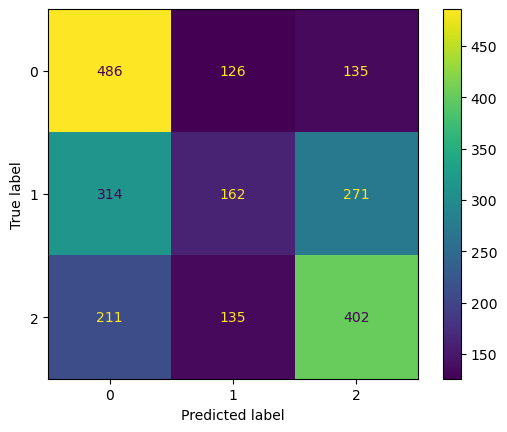

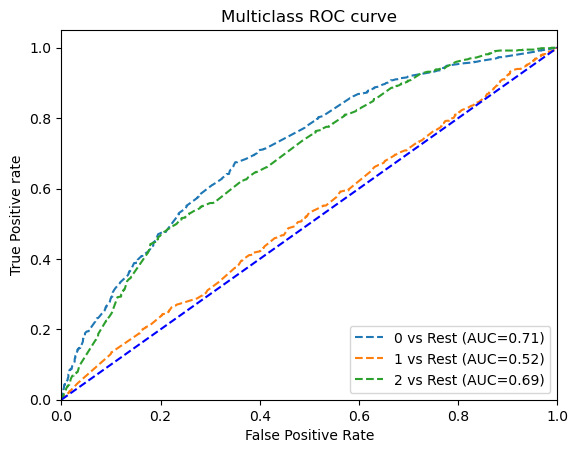

In [58]:
nn_conf1 = MLPClassifier()
nn_conf1.fit(lencoded_xtrain1, lencoded_ytrain1)
nn_conf_y_pred1 = nn_conf1.predict(lencoded_xtest1)
# print(nn_conf1.classes_)
confusion_matrix(nn_conf1.classes_, lencoded_ytest1, nn_conf_y_pred1)
roc1(lencoded_xtest1, lencoded_ytest1, nn_conf1)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to calculate learning curves for a classifier
def calculate_learning_curve(classifier, X, y_severity, train_sizes):

    train_scores_mean = []  
    train_scores_std = []   
    test_scores_mean = []   
    test_scores_std = []    

    # Iterate over different training set sizes
    for train_size in train_sizes:
        train_subset_size = int(train_size * X.shape[0])  # Subset size based on the training set size
        X_train_subset = X[:train_subset_size]            # Subset of the feature matrix
        y_train_subset = y_severity[:train_subset_size]   # Subset of the target variable

        classifier.fit(X_train_subset, y_train_subset)    # Fit the classifier on the subset

        train_scores = classifier.score(X_train_subset, y_train_subset)  # Training scores
        test_scores = classifier.score(X, y_severity)                    # Test scores

        train_scores_mean.append(train_scores)  
        train_scores_std.append(0)              
        test_scores_mean.append(test_scores)    
        test_scores_std.append(0)               
        
    return train_sizes, np.array(train_scores_mean), np.array(train_scores_std), np.array(test_scores_mean), np.array(test_scores_std)

# Function to plot learning curves for multiple classifiers
def lc(X, y_severity, models):
    fig, ax = plt.subplots(figsize=(10, 6))

    train_sizes = np.linspace(0.01, 1.0, 10)  # Array of training set sizes

    # Iterate over the classifiers
    for i, classifier in enumerate(models):
        # Calculate the learning curve for the classifier
        train_sizes, train_mean, train_std, test_mean, test_std = calculate_learning_curve(classifier, X, y_severity, train_sizes)

        # Plot the training and cross-validation scores
        ax.plot(train_sizes, train_mean, '--', label=f"{classifier.__class__.__name__} Training score")
        ax.plot(train_sizes, test_mean, label=f"{classifier.__class__.__name__} Cross-validation score")

        # Fill the area between the mean scores and their standard deviations
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
        ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)

    ax.set_title("Learning Curves for Different Classifiers")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("Accuracy Score")
    ax.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [60]:
print(lencoded_xtrain.shape)
print(lencoded_ytrain.shape)

# lencoded_xtrain, lencoded_xtest, lencoded_ytrain, lencoded_ytest 

(176232, 9)
(176232,)


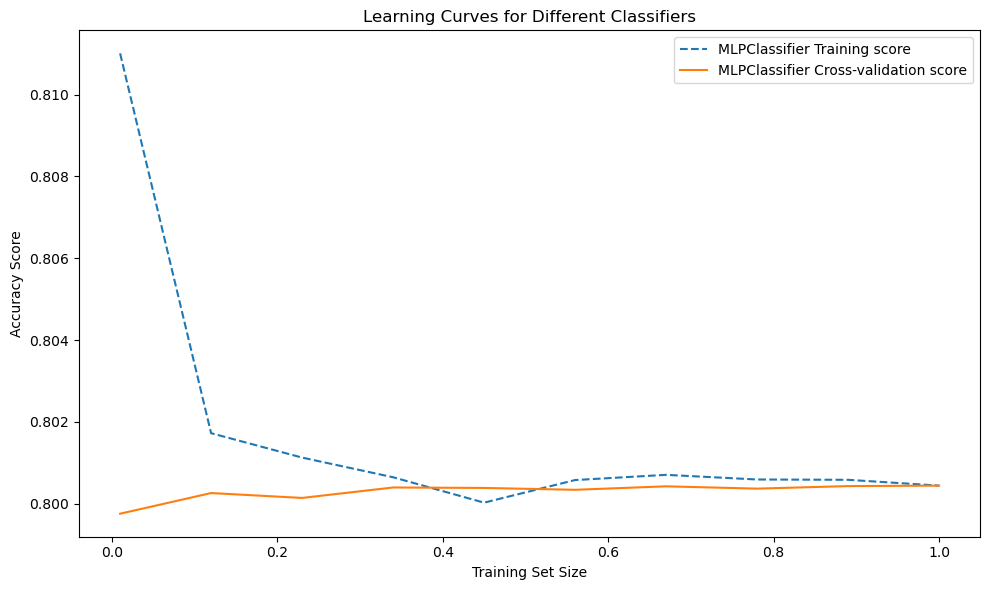

0.5323063637989311

In [61]:
import matplotlib.pyplot as plt

#Creating the model 

model = MLPClassifier()


lc(lencoded_xtrain, lencoded_ytrain,[model])
# Train the model on the training data

model.fit(lencoded_xtrain, lencoded_ytrain)

# Make predictions on the test data
y_pred = model.predict(lencoded_xtrain.head(50))

model.best_loss_

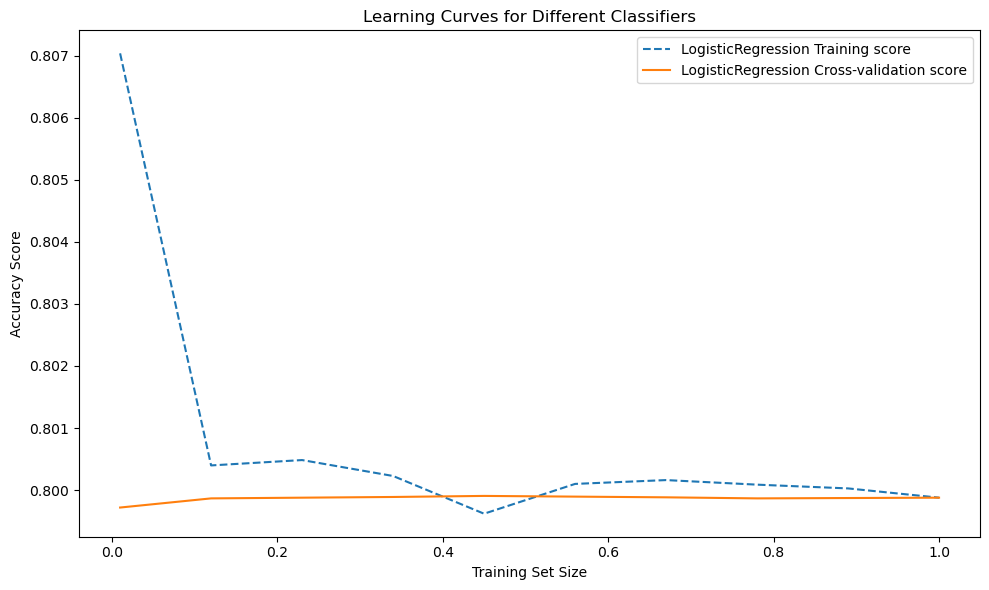

In [62]:
#Creating the model and adding regularisation layer. Also, maximum iterations are 1000 to avoid any warnings 

model = LogisticRegression(max_iter=1000,penalty="l2")

#The training and test data from the y_accident severity sample

lc(lencoded_xtrain, lencoded_ytrain,[model])

model.fit(lencoded_xtrain, lencoded_ytrain)

y_pred = model.predict(lencoded_xtrain.head(50))


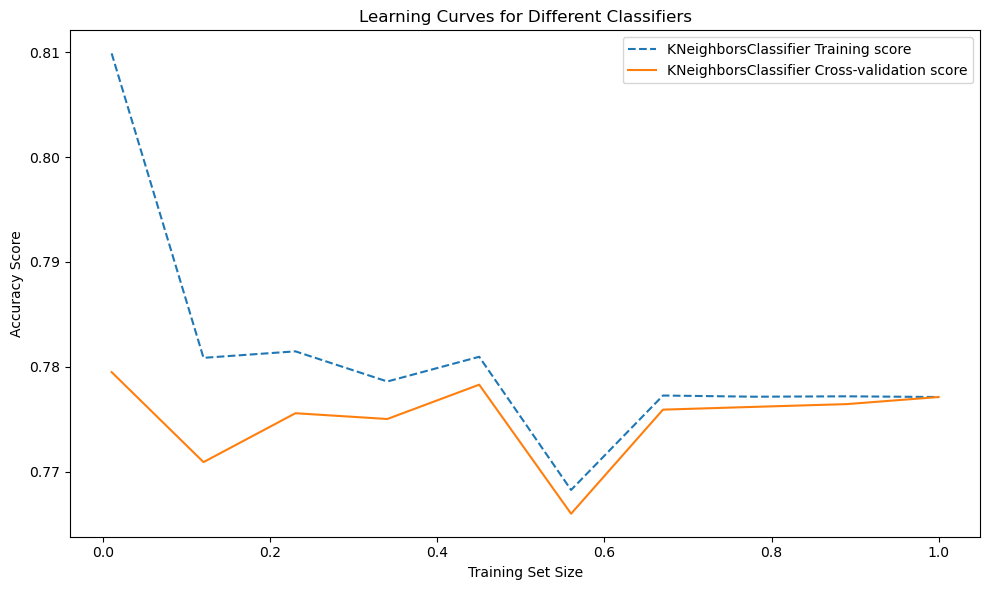

In [63]:
#Creating the model.

model = KNeighborsClassifier()

# Train data of y_detailed.

lc(lencoded_xtrain, lencoded_ytrain,[model])

model.fit(lencoded_xtrain, lencoded_ytrain)

y_pred = model.predict(lencoded_xtrain.head(50))


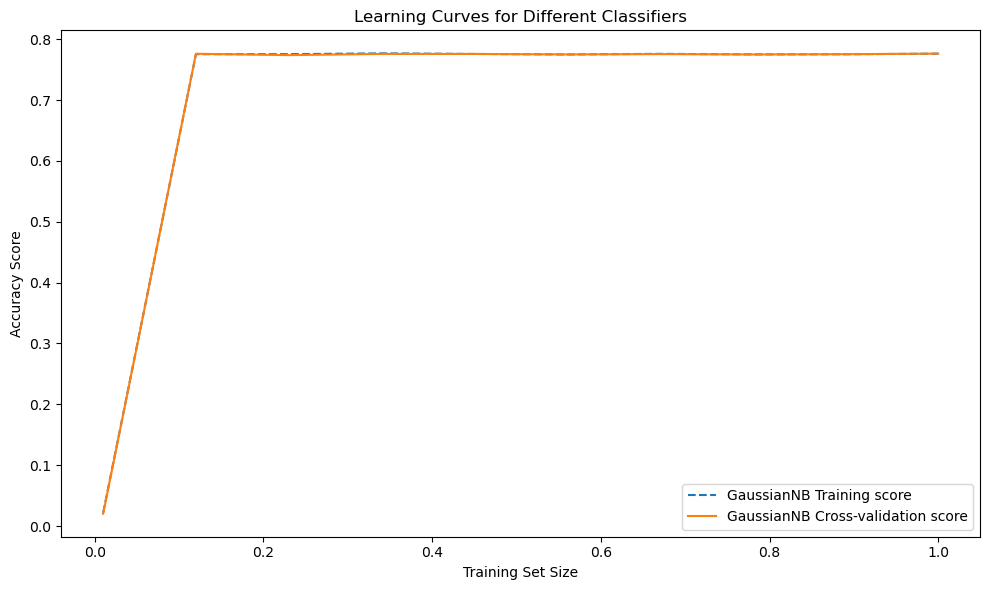

In [64]:
model = GaussianNB()

lc(lencoded_xtrain, lencoded_ytrain,[model])

model.fit(lencoded_xtrain, lencoded_ytrain)

y_pred = model.predict(lencoded_xtrain.head(50))
